In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion
import copy

import cc3d
import torch

from monai.metrics import compute_iou
import torch.nn.functional as F

from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric, SurfaceDistanceMetric

from scipy.ndimage import distance_transform_edt

#from panoptic_measure import panoptic_quality
import numpy as np
from scipy.ndimage import label
from skimage.metrics import adapted_rand_error
import torch
import nibabel as nib

import gc
import os

In [2]:
def calculate_iou(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    if union == 0:
        return 0
    return intersection / union

def panoptic_quality(pred_inp, gt_inp):
    threshold = 0.5  # Set IoU threshold to 0.5 as per the paper
    # Label connected components, ignore background!
    
    pred = pred_inp.argmax(dim=1).squeeze()
    gt = gt_inp.argmax(dim=1).squeeze()
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    #gt_labeled, gt_num = label(gt)
    #pred_labeled, pred_num = label(pred)
    
    # Track matching components and their IoU
    matches = []
    for gt_id in range(1, gt_num + 1):
        gt_component = (gt_labeled == gt_id)
        for pred_id in range(1, pred_num + 1):
            pred_component = (pred_labeled == pred_id)
            iou = calculate_iou(gt_component, pred_component)
            if iou > threshold:
                matches.append((iou, gt_id, pred_id))
    
    # Sort matches by IoU in descending order
    matches.sort(reverse=True, key=lambda x: x[0])
    
    # Track used components
    used_gt = set()
    used_pred = set()
    
    tp = 0  # True Positives
    sum_iou = 0
    
    for iou, gt_id, pred_id in matches:
        if gt_id not in used_gt and pred_id not in used_pred:
            tp += 1
            sum_iou += iou
            used_gt.add(gt_id)
            used_pred.add(pred_id)
    
    fp = pred_num - tp  # False Positives
    fn = gt_num - tp    # False Negatives
    
    # Calculate PQ
    if tp + fp + fn == 0:
        pq = 1.0
    else:
        pq = sum_iou / (tp + 0.5 * fp + 0.5 * fn)
    
    return torch.as_tensor(pq) 

In [3]:
def compute_all_metrics(cc_labels, array, s, drop_cc=False, caching_dir=".",caching_name="toy1.npy"):
    cc_dt = []

    if not drop_cc and os.path.exists(os.path.join(caching_dir,caching_name)):
        cc_asignment = np.load(os.path.join(caching_dir,caching_name))
    else:
        for cc in np.unique(cc_labels):
            if cc == 0:
                pass
            else:
                cc_dt.append(
                    distance_transform_edt(np.logical_not(cc_labels == cc)).astype(np.float32) 
                    #Convert to float 32 due to 64GB Ram limitation
                    )
        cc_asignment = np.argmin(np.stack(cc_dt),axis=0)+1
    if drop_cc:
        np.save(os.path.join(caching_dir,caching_name),cc_asignment)    
    original_labels = torch.from_numpy(array)
    cc_asignment = torch.from_numpy(cc_asignment)


    scenario_predictions = torch.from_numpy(s)
    
    cur_pred = F.one_hot(scenario_predictions.unsqueeze(0).long(),num_classes=2)
    cur_pred = cur_pred.permute(0,4,1,2,3)
    cur_labels = F.one_hot(original_labels.unsqueeze(0).long(),num_classes=2)
    cur_labels = cur_labels.permute(0,4,1,2,3)
    cur_cc_asignment = cc_asignment.unsqueeze(0)
    
    metrics = {
        "DiceMetric": DiceMetric(include_background=False, reduction="mean"),
        "HausdorffDistance": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=None, directed=False, reduction='mean', get_not_nans=False),
        "HausdorffDistance95": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean',percentile=95, directed=False, reduction='mean', get_not_nans=False),
        "SurfaceDistance": SurfaceDistanceMetric(include_background=False, symmetric=False, distance_metric='euclidean', reduction='mean', get_not_nans=False),
        "SurfaceDiceMetric": SurfaceDiceMetric(class_thresholds=[1] ,include_background=False, distance_metric='euclidean', reduction='mean', get_not_nans=False, use_subvoxels=False),
        "PanopticQuality": panoptic_quality
    }
    
    this_patients_predictions = {
        #"PatientID": "/".join(label_path.split("/")[-3:-1]),
        #"n":n,
        #"k":k,
        #"p":p,
        "nof_ccs": len(np.unique(cc_labels)),
        #"cc_indices": unique_labels.tolist(),
        #"cc_voxel_count": cc_voxel_counts.tolist(),
        #"affected_cc_regions": affected_regions_idx
    }
    
    
    #Aggregate predictions
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            pass
        else: 
            metric(y_pred=cur_pred, y=cur_labels)
    
    #Reduce predictions for this patient
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            global_metric_result = metric(cur_pred, cur_labels).item()
        else:
            global_metric_result = metric.aggregate().item()
        this_patients_predictions.update(
            {f"Global_{metric_name}":global_metric_result}
        )
        print(f"Global_{metric_name} -> {global_metric_result}")
        if metric_name !="PanopticQuality": metric.reset()
    
       
    
    cc_submetrics = {}
    
    #Report how many of the cc_regiond do not have any components
    missed_cc = 0
    
    for metric_name, metric in metrics.items():
        if metric_name !="PanopticQuality": metric.reset()
        
    for cc_id in cc_asignment.unique():
        
        pred_helper = copy.deepcopy(cur_pred).argmax(dim=1)
        label_helper = copy.deepcopy(cur_labels).argmax(dim=1)
        cc_mask = cur_cc_asignment == cc_id
        # Set the rest of gt and labels to background, to ignore during 
        pred_helper[
            torch.logical_not(cc_mask)
            ] = 0
        label_helper[
            torch.logical_not(cc_mask)
            ] = 0
        
    
        if pred_helper.sum() == 0:
            missed_cc += 1
        
        pred_helper = F.one_hot(pred_helper.long(),num_classes=2)
        pred_helper = pred_helper.permute(0,4,1,2,3)
        label_helper = F.one_hot(label_helper.long(),num_classes=2)
        label_helper = label_helper.permute(0,4,1,2,3)
    
        #Put into the the submetrics
        for metric_name, metric in metrics.items():
            
            
            if metric_name != "PanopticQuality":
                metric(y_pred=pred_helper, y=label_helper)
                submetric = metric.aggregate()
            else:
                submetric = metric(pred_helper, label_helper)
            
            if metric_name not in cc_submetrics:
                cc_submetrics.update({metric_name:[submetric.item()]})
            else:
                cc_submetrics[metric_name].append(submetric.item())
            
            if metric_name != "PanopticQuality": metric.reset()
    
            gc.collect()
    
    for metric_name, vals in cc_submetrics.items():
        aggregated_submetric = sum(vals)/len(vals)
        this_patients_predictions.update(
            {
                f"Submetric_{metric_name}_agg":aggregated_submetric,
                f"Submetric_{metric_name}_details":vals,
            }
        )
        print(f"Submetric_{metric_name} -> {aggregated_submetric}")
    this_patients_predictions.update(
        {f"Missed_cc_regions": missed_cc}
        )
    return this_patients_predictions

In [4]:
array = nib.load("array.nii.gz").get_fdata()

In [5]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)

In [6]:
np.unique(array)

array([0., 1.])

In [7]:
results = [compute_all_metrics(cc_labels,array,s,drop_cc=True)]
for i in range(20):
    s = binary_erosion(s,structure=structuring_element)
    res = compute_all_metrics(cc_labels,array,s)
    results.append(res)

Global_DiceMetric -> 1.0
Global_HausdorffDistance -> 0.0
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.0
Global_SurfaceDiceMetric -> 1.0
Global_PanopticQuality -> 1.0
Submetric_DiceMetric -> 1.0
Submetric_HausdorffDistance -> 0.0
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> 0.0
Submetric_SurfaceDiceMetric -> 1.0
Submetric_PanopticQuality -> 1.0
Global_DiceMetric -> 0.9741848707199097
Global_HausdorffDistance -> 1.7320507764816284
Global_HausdorffDistance95 -> 1.7320507764816284
Global_SurfaceDistance -> 1.3766080141067505
Global_SurfaceDiceMetric -> 0.2771017849445343
Global_PanopticQuality -> 0.8860109222244915
Submetric_DiceMetric -> 0.9380615552266439
Submetric_HausdorffDistance -> 1.7320507764816284
Submetric_HausdorffDistance95 -> 1.7320507764816284
Submetric_SurfaceDistance -> 1.3732307354609172
Submetric_SurfaceDiceMetric -> 0.2764510711034139
Submetric_PanopticQuality -> 0.8860109222244915
Global_DiceMetric -> 0.9479402303695679
Global_Hausd

/home/ajaus/AAAI_2025/CC_Metric/MONAI/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Submetric_DiceMetric -> 0.3623732924461365
Submetric_HausdorffDistance -> inf
Submetric_HausdorffDistance95 -> 13.531845092773438
Submetric_SurfaceDistance -> inf
Submetric_SurfaceDiceMetric -> 0.0
Submetric_PanopticQuality -> 0.18045109969091278
Global_DiceMetric -> 0.6419344544410706
Global_HausdorffDistance -> 140.03213500976562
Global_HausdorffDistance95 -> 22.226110458374023
Global_SurfaceDistance -> 19.609243392944336
Global_SurfaceDiceMetric -> 0.0
Global_PanopticQuality -> 0.20413452994681816
Submetric_DiceMetric -> 0.3370361328125
Submetric_HausdorffDistance -> inf
Submetric_HausdorffDistance95 -> 14.681802749633789
Submetric_SurfaceDistance -> inf
Submetric_SurfaceDiceMetric -> 0.0
Submetric_PanopticQuality -> 0.17011210828901513
Global_DiceMetric -> 0.6136277914047241
Global_HausdorffDistance -> 141.84498596191406
Global_HausdorffDistance95 -> 23.93741798400879
Global_SurfaceDistance -> 21.18866539001465
Global_SurfaceDiceMetric -> 0.0
Global_PanopticQuality -> 0.0
Submetric

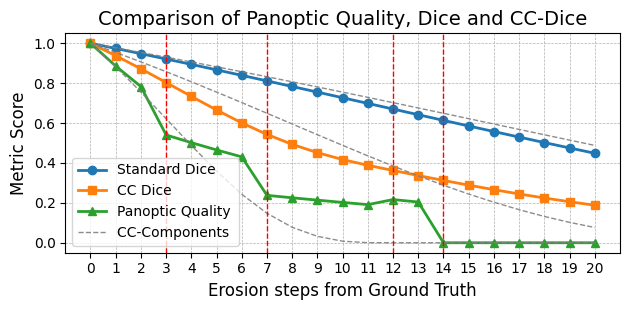

In [8]:
plt.figure(figsize=(6.4, 3.2))
plt.plot([x["Global_DiceMetric"] for x in results], label="Standard Dice", linewidth=2, marker='o')
plt.plot([x["Submetric_DiceMetric_agg"] for x in results], label="CC Dice", linewidth=2, marker='s')
plt.plot([x["Global_PanopticQuality"] for x in results], label="Panoptic Quality", linewidth=2, marker='^')

plt.plot([x["Submetric_DiceMetric_details"][0] for x in results],linestyle="dashed",alpha=0.9,color="grey",linewidth=1)
plt.plot([x["Submetric_DiceMetric_details"][1] for x in results],linestyle='dashed',alpha=0.9,color="grey",linewidth=1)
plt.plot([x["Submetric_DiceMetric_details"][2] for x in results],linestyle='dashed',alpha=0.9,color="grey",label="CC-Components ",linewidth=1)


# Add gridlines
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Add legend with better placement
plt.legend(loc="best", fontsize=10, frameon=True)

# Set axis labels with larger fonts
plt.ylabel("Metric Score", fontsize=12)
plt.xlabel("Erosion steps from Ground Truth", fontsize=12)

# Set x-ticks
plt.xticks(ticks=range(0, len(results)), labels=range(0, len(results)), fontsize=10)

# Improve the format of y-axis tick labels
#plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Set the plot's title
plt.title("Comparison of Panoptic Quality, Dice and CC-Dice", fontsize=14)

highlight_steps = [3, 7, 12, 14]
for step in highlight_steps:
    plt.axvline(x=step, color='red', linestyle='--', linewidth=1)

# Save the plot as a high-resolution image
plt.tight_layout()
#plt.savefig("PQ_vs_CC_Dice_small_small_include_components.pdf")